In [ ]:
# %pip install -r C:\Users\sriha\Downloads\resume\pairs-trading\requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached pandas-2.3.0-cp313-cp313-win_amd64.whl.metadata (19 kB)
  Using cached numpy-2.3.1-cp313-cp313-win_amd64.whl.metadata (60 kB)
  Using cached yfinance-0.2.65-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached matplotlib-3.10.3-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached pytz-2025.2-py2.py3-none-any.whl.metadata (22 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
  Using cached patsy-1.0.1-py2.py3-none-any.whl.metadata (3.3 kB)
  Using cached requests-2.32.4-py3-none-any.whl.metadata (4.9 kB)
  Using cached multitasking-0.0.11-py3-none-any.whl.metadata (5.5 kB)
  Using cached frozendict-2.4.6-py313-none-any.whl.metadata (23 kB)
  Using cached peewee-3.18.1-py3-none-any.whl
  Using cached beautifulsoup4-4.13.4-py3-none-any.whl.metadata (3.8 kB)
  Using cached curl_cffi-0.11.4-cp39-abi3-win_amd


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

plt.style.use("seaborn-v0_8-darkgrid")
%matplotlib inline

DATA_DIR = "../data/"


In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_context("talk")

DATA_DIR = "../data/"

def load_all_prices(data_dir, price_col="Close", verbose=True):
    price_dfs = []

    for file in os.listdir(data_dir):
        if file.endswith(".csv"):
            ticker = file.replace(".csv", "")
            path = os.path.join(data_dir, file)

            try:
                df = pd.read_csv(path, skiprows=[1])
                df.rename(columns=lambda x: x.strip(), inplace=True)

                if "Date" in df.columns:
                    df.rename(columns={"Date": "timestamp"}, inplace=True)
                if "timestamp" not in df.columns:
                    raise ValueError("No timestamp column found.")

                df["timestamp"] = pd.to_datetime(df["timestamp"])
                if price_col not in df.columns:
                    raise ValueError(f"'{price_col}' column not found.")

                df = df[["timestamp", price_col]].rename(columns={price_col: ticker})
                df.set_index("timestamp", inplace=True)
                price_dfs.append(df)

            except Exception as e:
                if verbose:
                    print(f"Skipping {ticker}: {e}")

    combined = pd.concat(price_dfs, axis=1, join="outer")
    combined.sort_index(inplace=True)
    combined.fillna(method="ffill", inplace=True)
    combined.dropna(axis=1, inplace=True)

    return combined

prices = load_all_prices(DATA_DIR)
print("Tickers loaded:", list(prices.columns))
prices.tail()


Tickers loaded: ['COP', 'CVX', 'JNJ', 'KO', 'PEP', 'PG', 'WMT', 'XOM']


C:\Users\sriha\AppData\Local\Temp\ipykernel_30544\3876228319.py:43: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  combined.fillna(method="ffill", inplace=True)


,COP,CVX,JNJ,KO,PEP,PG,WMT,XOM
timestamp,,,,,,,,
2024-12-23,94.797394,139.700027,142.891403,61.485874,148.336456,166.056046,89.885246,104.396103
2024-12-24,95.515411,140.550125,143.461914,61.939281,149.826782,166.875900,92.203255,104.494308
2024-12-26,95.299026,140.686920,143.196320,61.673145,149.464020,168.081009,92.312691,104.582695
2024-12-27,95.328529,140.706467,142.675018,61.554871,149.905228,167.458694,91.188515,104.572876
2024-12-30,95.495735,139.797745,140.992996,61.140888,148.758087,165.048508,90.104111,103.865776


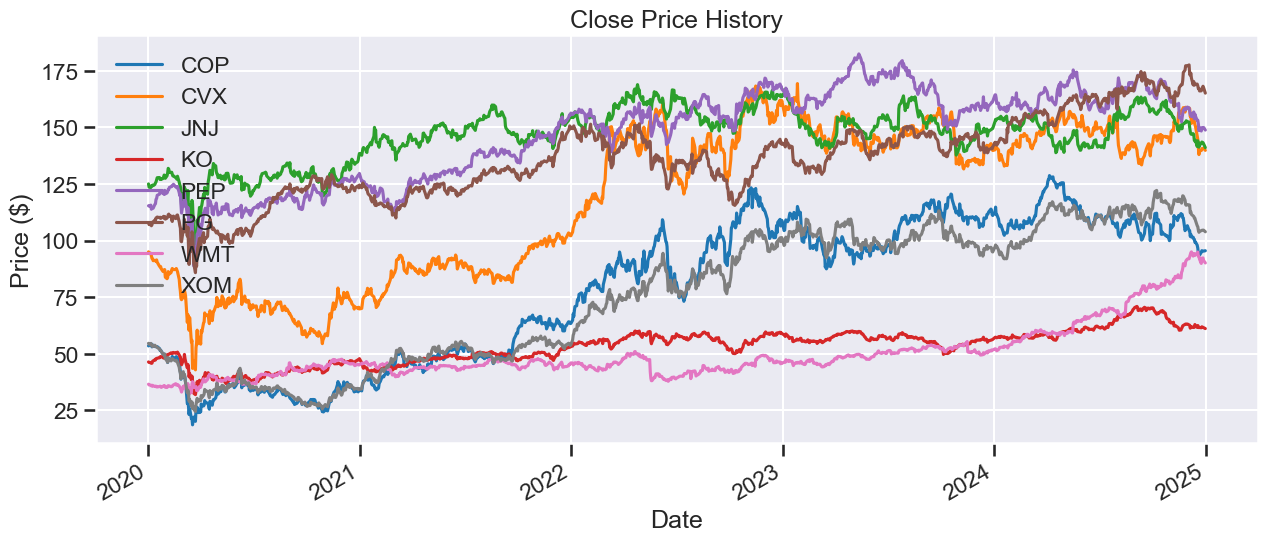

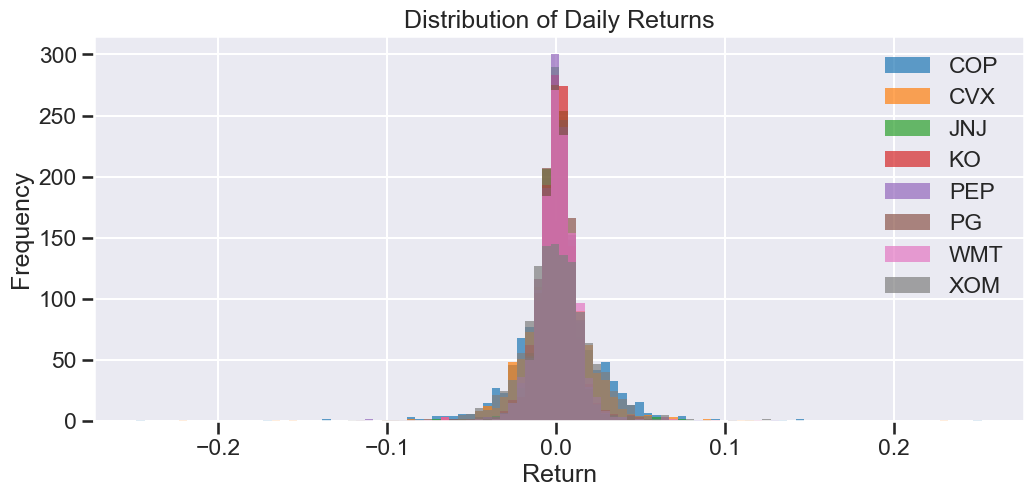

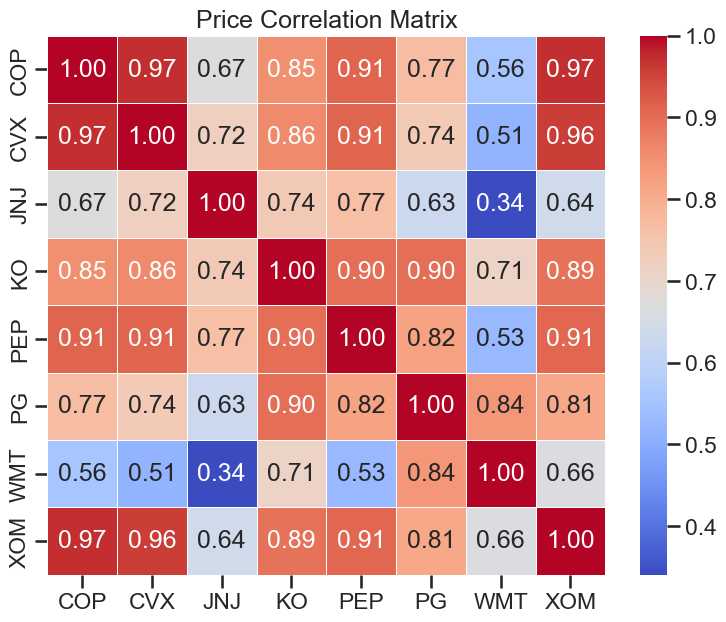

In [ ]:
# Price trends
prices.plot(figsize=(15, 6), title="Close Price History")
plt.ylabel("Price ($)")
plt.xlabel("Date")
plt.show()

returns = prices.pct_change().dropna()

returns.plot.hist(bins=100, alpha=0.7, figsize=(12, 5))
plt.title("Distribution of Daily Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()
plt.figure(figsize=(9, 7))
sns.heatmap(prices.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Price Correlation Matrix")
plt.show()


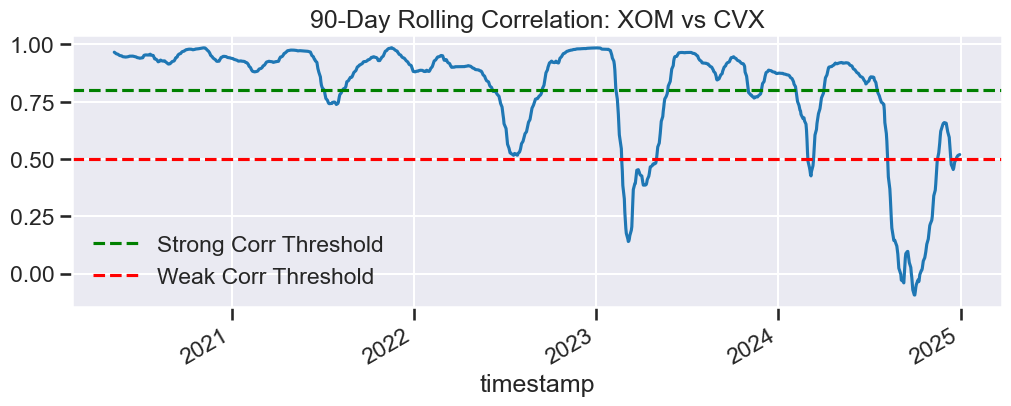

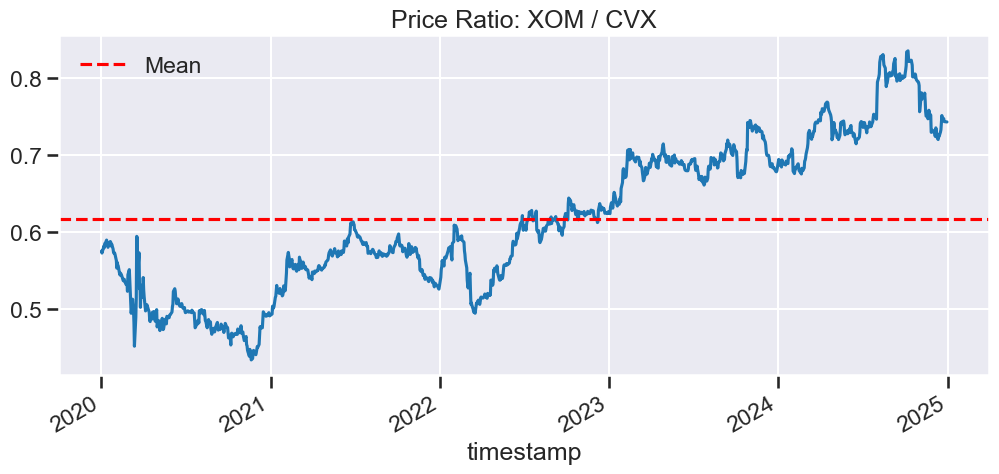

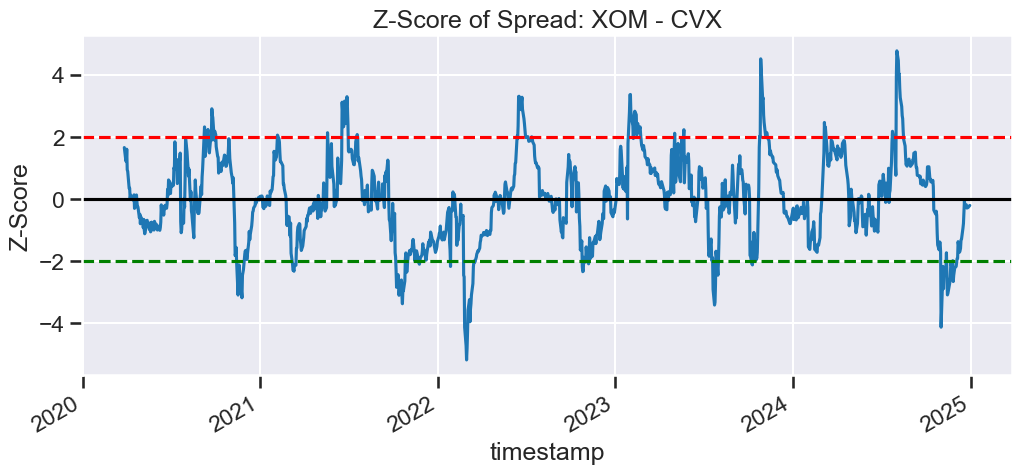

In [ ]:
ticker1, ticker2 = "XOM", "CVX"
rolling_corr = prices[ticker1].rolling(90).corr(prices[ticker2])

rolling_corr.plot(figsize=(12, 4), title=f"90-Day Rolling Correlation: {ticker1} vs {ticker2}")
plt.axhline(0.8, color='green', linestyle='--', label='Strong Corr Threshold')
plt.axhline(0.5, color='red', linestyle='--', label='Weak Corr Threshold')
plt.legend()
plt.show()

ratio = prices[ticker1] / prices[ticker2]
ratio.plot(figsize=(12, 5), title=f"Price Ratio: {ticker1} / {ticker2}")
plt.axhline(ratio.mean(), color='red', linestyle='--', label='Mean')
plt.legend()
plt.show()

spread = prices[ticker1] - prices[ticker2]
zscore = (spread - spread.rolling(60).mean()) / spread.rolling(60).std()

zscore.plot(figsize=(12, 5), title=f"Z-Score of Spread: {ticker1} - {ticker2}")
plt.axhline(0, color='black')
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='green', linestyle='--')
plt.ylabel("Z-Score")
plt.show()
